# 1. IMPORT DES LIBRAIRIES

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# 2. CHARGEMENT DES DONNÉES

In [10]:
df = pd.read_csv('data_cleaned.csv')
print(f"{df.shape[0]} lignes, {df.shape[1]} colonnes")

2216 lignes, 31 colonnes


# 3. FEATURE ENGINEERING

In [12]:
# Création de variables pertinentes
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Has_Children'] = (df['Total_Children'] > 0).astype(int)
df['Total_Purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
df['Avg_Basket'] = df['Total_Spent'] / df['Total_Purchases'].replace(0, 1)

# Segmentation des revenus
df['Income_Category'] = pd.cut(df['Income'], 
                                 bins=[0, 30000, 60000, 100000, np.inf],
                                 labels=['Faible', 'Moyen', 'Élevé', 'Très élevé'])

print(" Nouvelles variables créées:")
print("  • Total_Children - Nombre total d'enfants")
print("  • Has_Children - Présence d'enfants (binaire)")
print("  • Total_Purchases - Nombre total d'achats")
print("  • Avg_Basket - Panier moyen")
print("  • Income_Category - Catégorie de revenu")

 Nouvelles variables créées:
  • Total_Children - Nombre total d'enfants
  • Has_Children - Présence d'enfants (binaire)
  • Total_Purchases - Nombre total d'achats
  • Avg_Basket - Panier moyen
  • Income_Category - Catégorie de revenu


# 4. SÉLECTION DES VARIABLES POUR LE CLUSTERING

In [16]:
features = ['Income', 'Age', 'Total_Spent', 'Total_Purchases', 
            'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
            'NumWebVisitsMonth', 'Recency', 'Total_Children']

print("\n Variables sélectionnées:")
for i, feat in enumerate(features, 1):
    print(f"  {i}. {feat}")

# Création du DataFrame pour le clustering
X = df[features].copy()
print(f"\n Matrice X créée: {X.shape[0]} échantillons, {X.shape[1]} features")


 Variables sélectionnées:
  1. Income
  2. Age
  3. Total_Spent
  4. Total_Purchases
  5. NumWebPurchases
  6. NumCatalogPurchases
  7. NumStorePurchases
  8. NumWebVisitsMonth
  9. Recency
  10. Total_Children

 Matrice X créée: 2216 échantillons, 10 features


# 5. STANDARDISATION

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

X_scaled.describe().round(2)

,Income,Age,Total_Spent,Total_Purchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Recency,Total_Children
count,2216.00,2216.00,2216.00,2216.00,2216.00,2216.00,2216.00,2216.00,2216.00,2216.00
mean,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.01,-2.27,-1.00,-1.74,-1.49,-0.91,-1.78,-2.19,-1.69,-1.26
25%,-0.67,-0.68,-0.89,-0.91,-0.76,-0.91,-0.86,-0.96,-0.86,-1.26
50%,-0.03,-0.10,-0.35,-0.08,-0.03,-0.23,-0.25,0.28,-0.00,0.07
75%,0.65,0.82,0.73,0.76,0.70,0.45,0.68,0.69,0.86,0.07
max,24.41,6.33,3.18,2.70,8.36,8.66,2.22,6.05,1.73,2.74


# 6. DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS

  k=2: Inertie=13700, Silhouette=0.346
  k=3: Inertie=12023, Silhouette=0.262
  k=4: Inertie=11064, Silhouette=0.182
  k=5: Inertie=10385, Silhouette=0.171
  k=6: Inertie=9883, Silhouette=0.168
  k=7: Inertie=9404, Silhouette=0.157
  k=8: Inertie=8924, Silhouette=0.148
  k=9: Inertie=8450, Silhouette=0.161
  k=10: Inertie=8193, Silhouette=0.159


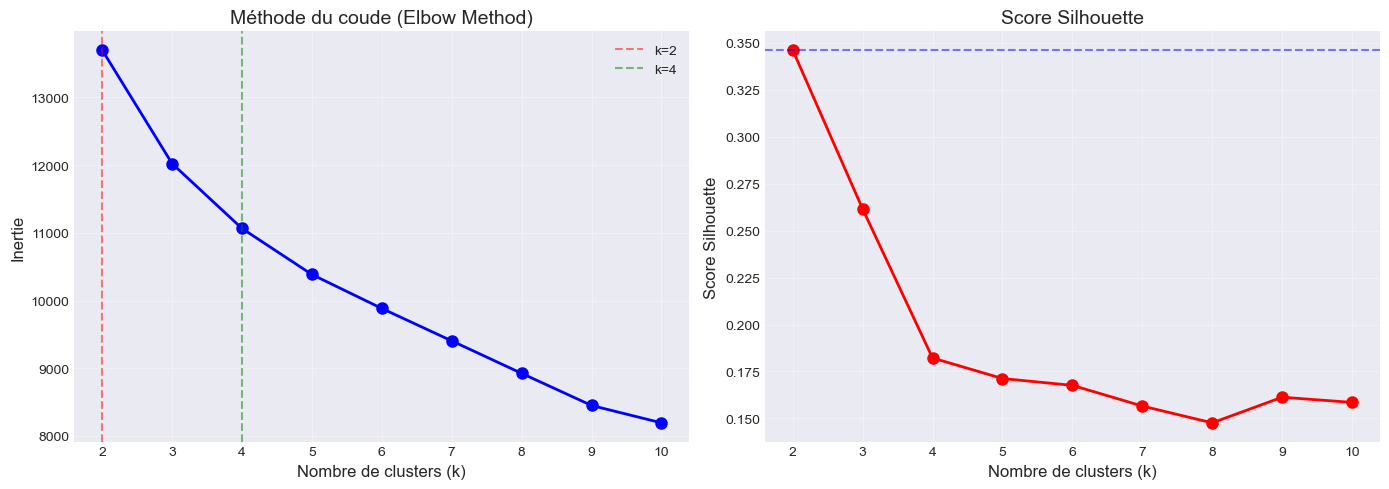


 Nombre optimal selon silhouette: 2


In [46]:
# Test de différents nombres de clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"  k={k}: Inertie={kmeans.inertia_:.0f}, Silhouette={silhouette_scores[-1]:.3f}")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Nombre de clusters (k)', fontsize=12)
ax1.set_ylabel('Inertie', fontsize=12)
ax1.set_title('Méthode du coude (Elbow Method)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='k=2')
ax1.axvline(x=4, color='green', linestyle='--', alpha=0.5, label='k=4')
ax1.legend()

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Nombre de clusters (k)', fontsize=12)
ax2.set_ylabel('Score Silhouette', fontsize=12)
ax2.set_title('Score Silhouette', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=max(silhouette_scores), color='blue', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Sélection automatique
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
print(f"\n Nombre optimal selon silhouette: {optimal_k_silhouette}")

# 7. APPLICATION DU CLUSTERING (K-MEANS)

In [ ]:
# Choix du nombre de clusters
n_clusters = 3  
print(f"\n🔧 Nombre de clusters retenu: {n_clusters}")

# Application du modèle
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print("\n Clustering terminé")
print(f"\n Distribution des clusters:")
print(df['Cluster'].value_counts().sort_index())


🔧 Nombre de clusters retenu: 3

 Clustering terminé

 Distribution des clusters:
Cluster
0    1047
1     520
2     649
Name: count, dtype: int64


# 8. VISUALISATION AVEC PCA


Variance expliquée:
  • PC1: 47.7%
  • PC2: 12.2%
  • PC2: 10.3%
  • Total: 70.1%


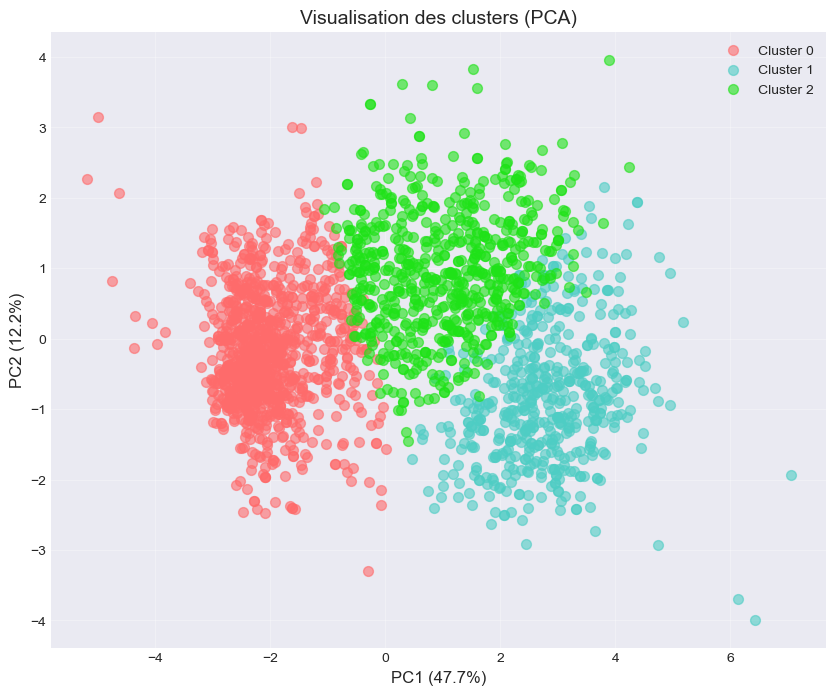

In [28]:
# Réduction de dimension
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
explained_variance = pca.explained_variance_ratio_
print(f"\nVariance expliquée:")
print(f"  • PC1: {explained_variance[0]*100:.1f}%")
print(f"  • PC2: {explained_variance[1]*100:.1f}%")
print(f"  • PC2: {explained_variance[2]*100:.1f}%")
print(f"  • Total: {sum(explained_variance)*100:.1f}%")

# Visualisation
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', "#1FE218", '#96CEB4', '#FFEEAD', '#D4A5A5']
for cluster in range(n_clusters):
    cluster_points = X_pca[df['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=colors[cluster % len(colors)], 
                label=f'Cluster {cluster}', alpha=0.6, s=50)

plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=12)
plt.title('Visualisation des clusters (PCA)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 9. PROFIL MOYEN PAR CLUSTER

In [44]:
# Calcul des moyennes
cluster_profile = df.groupby('Cluster')[features].mean().round(2)
cluster_size = df.groupby('Cluster').size()

print("\n Taille des clusters:")
for cluster in range(n_clusters):
    print(f"  • Cluster {cluster}: {cluster_size[cluster]} clients ({cluster_size[cluster]/len(df)*100:.1f}%)")



 Taille des clusters:
  • Cluster 0: 1047 clients (47.2%)
  • Cluster 1: 520 clients (23.5%)
  • Cluster 2: 649 clients (29.3%)


In [ ]:
print("\n Profil moyen:")
cluster_profile


📊 Profil moyen:


,Income,Age,Total_Spent,Total_Purchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Recency,Total_Children
Cluster,,,,,,,,,,
0,35077.08,52.76,100.98,5.92,2.13,0.57,3.22,6.47,49.06,1.26
1,78085.30,56.11,1397.52,19.62,4.77,6.44,8.41,2.51,50.74,0.16
2,59244.77,58.33,790.21,17.61,6.69,3.04,7.88,5.72,47.55,1.08


In [43]:
# 10. TESTS STATISTIQUES
from scipy import stats

print("\n Test t de Student (différences entre clusters):")
for col in ['Income', 'Age', 'Total_Spent', 'Total_Purchases']:
    cluster0 = df[df['Cluster'] == 0][col]
    cluster1 = df[df['Cluster'] == 1][col]
    t_stat, p_value = stats.ttest_ind(cluster0, cluster1)
    significance = " Différence significative" if p_value < 0.05 else " Pas de différence"
    print(f"  • {col}: p-value = {p_value:.4f} - {significance}")


 Test t de Student (différences entre clusters):
  • Income: p-value = 0.0000 -  Différence significative
  • Age: p-value = 0.0000 -  Différence significative
  • Total_Spent: p-value = 0.0000 -  Différence significative
  • Total_Purchases: p-value = 0.0000 -  Différence significative



VISUALISATION COMPARATIVE


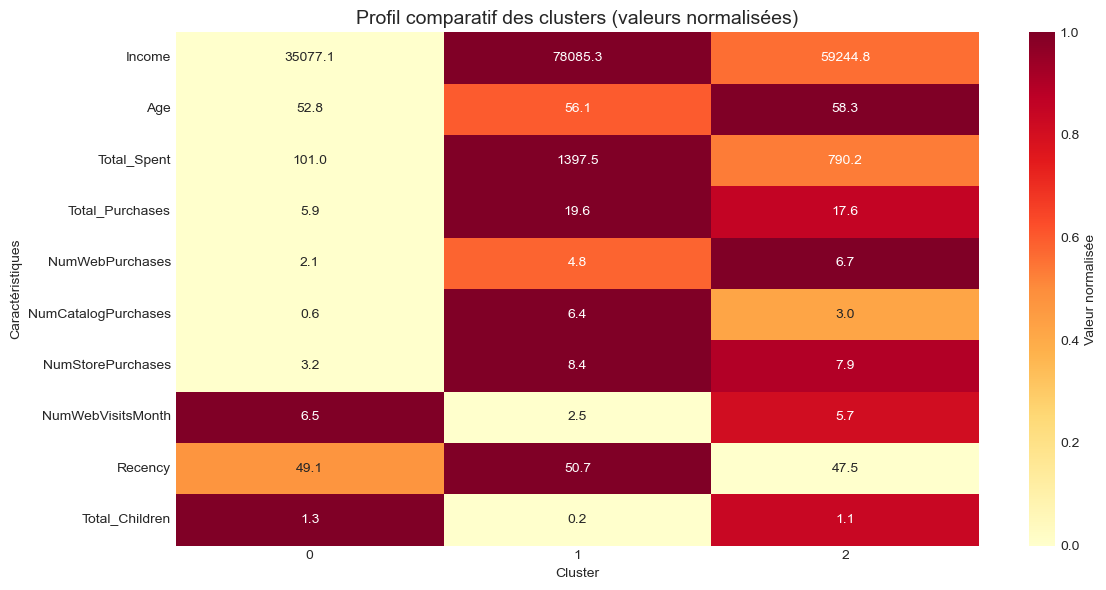

In [ ]:
# 11. HEATMAP DES CARACTÉRISTIQUES
# Normalisation pour la heatmap
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()
cluster_profile_norm = scaler_mm.fit_transform(cluster_profile)
cluster_profile_norm = pd.DataFrame(cluster_profile_norm, 
                                     columns=cluster_profile.columns, 
                                     index=cluster_profile.index)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile_norm.T, annot=cluster_profile.T, fmt='.1f', 
            cmap='YlOrRd', cbar_kws={'label': 'Valeur normalisée'})
plt.title('Profil comparatif des clusters (valeurs normalisées)', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Caractéristiques')
plt.tight_layout()
plt.show()

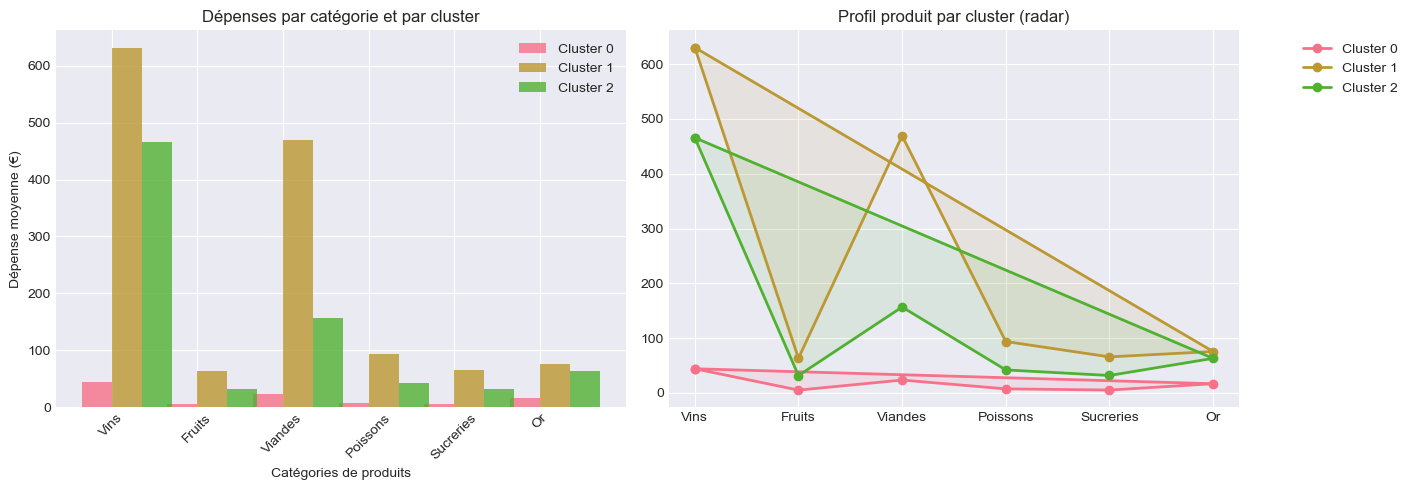


 Dépenses moyennes par produit et cluster:
         MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Cluster                                                          
0           43.91       4.92            23.28             7.24   
1          630.45      63.08           469.31            93.66   
2          465.75      31.51           156.62            41.79   

         MntSweetProducts  MntGoldProds  
Cluster                                  
0                    5.03         16.60  
1                   65.60         75.42  
2                   31.62         62.92  


In [42]:
# 12. ANALYSE DES PRODUITS PAR CLUSTER
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
product_names = ['Vins', 'Fruits', 'Viandes', 'Poissons', 'Sucreries', 'Or']

product_profile = df.groupby('Cluster')[product_cols].mean()

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres groupées
x = np.arange(len(product_names))
width = 0.35

for i in range(n_clusters):
    axes[0].bar(x + i*width, product_profile.iloc[i], width, 
                label=f'Cluster {i}', alpha=0.8)

axes[0].set_xlabel('Catégories de produits')
axes[0].set_ylabel('Dépense moyenne (€)')
axes[0].set_title('Dépenses par catégorie et par cluster')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(product_names, rotation=45)
axes[0].legend()

# Graphique en radar (optionnel mais visuel)
from math import pi

# Préparer les données pour le radar
categories = product_names
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

for i in range(n_clusters):
    values = product_profile.iloc[i].values.tolist()
    values += values[:1]
    
    axes[1].plot(angles, values, 'o-', linewidth=2, label=f'Cluster {i}')
    axes[1].fill(angles, values, alpha=0.1)

axes[1].set_xticks(angles[:-1])
axes[1].set_xticklabels(categories)
axes[1].set_title('Profil produit par cluster (radar)')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print("\n Dépenses moyennes par produit et cluster:")
print(product_profile.round(2))



In [41]:
# 13. SYNTHÈSE DU CLUSTERING
print("\n" + "="*60)
print("SYNTHÈSE DU CLUSTERING")
print("="*60)

print("""
 RÉSULTATS CLÉS:
------------------""")

print(f"\n• {n_clusters} segments clients identifiés")
print(f"• Score silhouette: {max(silhouette_scores):.3f}")
print(f"• Tous les indicateurs montrent des différences significatives")

# Calculer directement les canaux préférés à partir des données brutes
print("\n Caractéristiques distinctives:")
for cluster in range(n_clusters):
    # Filtrer les données pour ce cluster
    cluster_data = df[df['Cluster'] == cluster]
    
    # Calculer les moyennes des canaux pour ce cluster
    web_mean = cluster_data['NumWebPurchases'].mean()
    catalog_mean = cluster_data['NumCatalogPurchases'].mean()
    store_mean = cluster_data['NumStorePurchases'].mean()
    
    # Déterminer le canal préféré
    means = [web_mean, catalog_mean, store_mean]
    channels = ['Web', 'Catalogue', 'Magasin']
    preferred_channel = channels[np.argmax(means)]
    
    print(f"\n  Cluster {cluster}:")
    print(f"    - Âge: {cluster_profile.loc[cluster, 'Age']:.1f} ans")
    print(f"    - Revenu: {cluster_profile.loc[cluster, 'Income']:.0f}€")
    print(f"    - Dépenses: {cluster_profile.loc[cluster, 'Total_Spent']:.0f}€")
    print(f"    - Canal préféré: {preferred_channel}")
    print(f"      (Web: {web_mean:.1f}, Catalogue: {catalog_mean:.1f}, Magasin: {store_mean:.1f})")


SYNTHÈSE DU CLUSTERING

 RÉSULTATS CLÉS:
------------------

• 3 segments clients identifiés
• Score silhouette: 0.346
• Tous les indicateurs montrent des différences significatives

 Caractéristiques distinctives:

  Cluster 0:
    - Âge: 52.8 ans
    - Revenu: 35077€
    - Dépenses: 101€
    - Canal préféré: Magasin
      (Web: 2.1, Catalogue: 0.6, Magasin: 3.2)

  Cluster 1:
    - Âge: 56.1 ans
    - Revenu: 78085€
    - Dépenses: 1398€
    - Canal préféré: Magasin
      (Web: 4.8, Catalogue: 6.4, Magasin: 8.4)

  Cluster 2:
    - Âge: 58.3 ans
    - Revenu: 59245€
    - Dépenses: 790€
    - Canal préféré: Magasin
      (Web: 6.7, Catalogue: 3.0, Magasin: 7.9)


In [ ]:
# Sauvegarde
df.to_csv('data_with_clusters.csv', index=False)
print("\n Données avec clusters sauvegardées dans 'data_with_clusters.csv'")


💾 Données avec clusters sauvegardées dans 'data_with_clusters.csv'
